# Sample captions & visualize attention

In [1]:
import sys; sys.argv=['']; del sys
import numpy as np
import os
from args import get_parser
from utils.dataloader import DataLoader
from utils.config import get_opt
from utils.lang_proc import idx2word, sample, beamsearch
from model import get_model
import pickle

Using TensorFlow backend.


In [2]:
parser = get_parser()
args_dict = parser.parse_args()
args_dict.mode = 'test'
args_dict.bs = 1
args_dict.cnntrain = True

Choose model weights to load:

In [3]:
args_dict.model_file = '/work/asalvador/sat_keras/models/model_weights.00-2.32.h5'

Initialize model and load weights:

In [4]:
model = get_model(args_dict)
opt = get_opt(args_dict)

weights = args_dict.model_file
model.load_weights(weights)

model.compile(optimizer=opt,loss='categorical_crossentropy')

Initialize the generator to yield samples:

In [5]:
dataloader = DataLoader(args_dict)
N = args_dict.bs
val_gen = dataloader.generator('test',batch_size=args_dict.bs,train_flag=False) # N samples

Create the extractor that outputs attention weights and class probabilities

In [6]:
from keras.models import Model
att_layer = 'att_scores'
extractor = Model(input=model.input,output=[model.output,model.get_layer(att_layer).output])

Load the word vocabulary to map idxs to words:

In [7]:
vocab_file = os.path.join(args_dict.data_folder,'data',args_dict.vfile)
vocab = pickle.load(open(vocab_file,'rb'))
inv_vocab = {v:k for k,v in vocab.items()}

In [8]:
figsize = (30,30)

# parameters to manipulate attention weights
sig = 5
th = 0.3

224


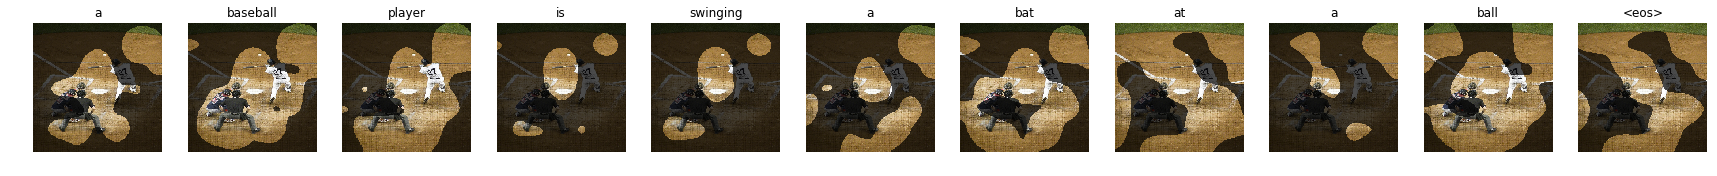

('ID:', u'COCO_val2014_000000364073.jpg')
('True:', u'a player in action up to bat in a baseball game . <eos>')
('Gen:', u'a baseball player is swinging a bat at a ball <eos>')
----------
224


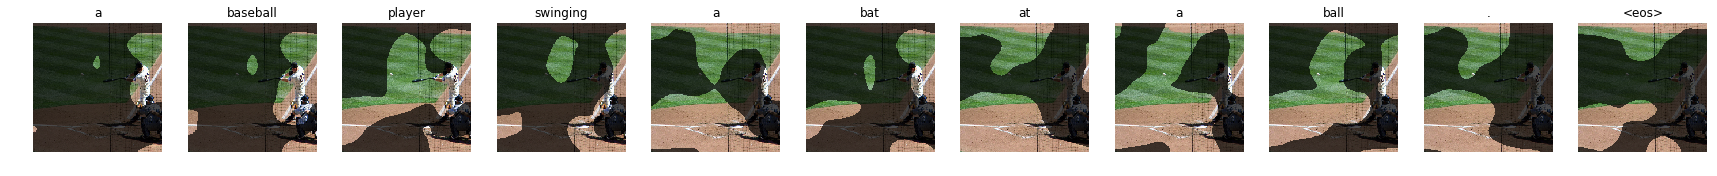

('ID:', u'COCO_val2014_000000142742.jpg')
('True:', u'a baseball player hitting a ball with a bat . <eos>')
('Gen:', u'a baseball player swinging a bat at a ball . <eos>')
----------
224


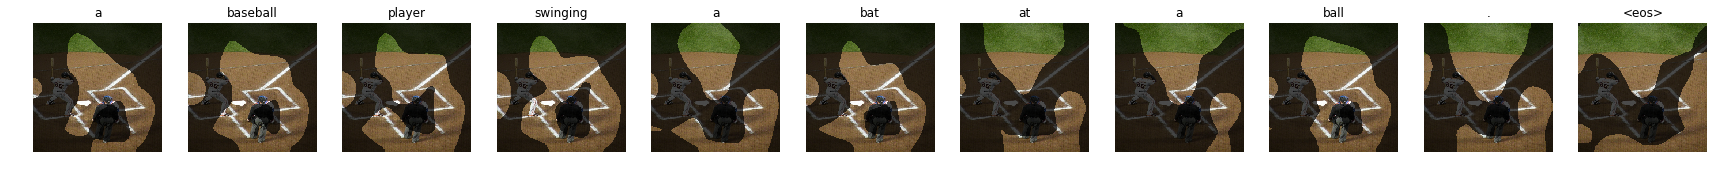

('ID:', u'COCO_val2014_000000368576.jpg')
('True:', u'a baseball player holding a bat next to home plate . <eos>')
('Gen:', u'a baseball player swinging a bat at a ball . <eos>')
----------
224


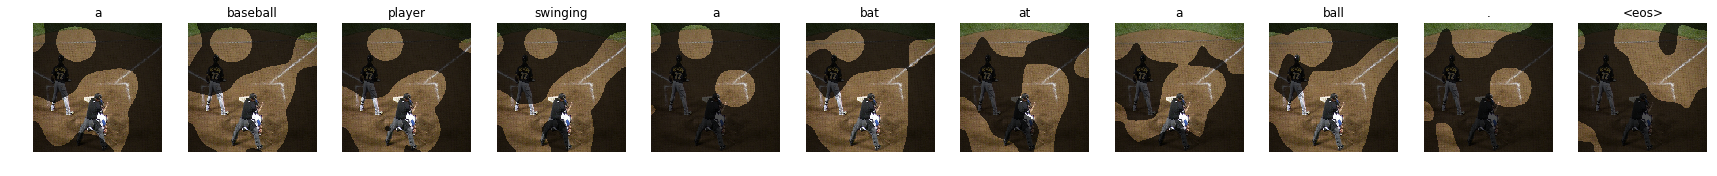

('ID:', u'COCO_val2014_000000128142.jpg')
('True:', u'a team of baseball players playing a game of baseball . <eos>')
('Gen:', u'a baseball player swinging a bat at a ball . <eos>')
----------
224


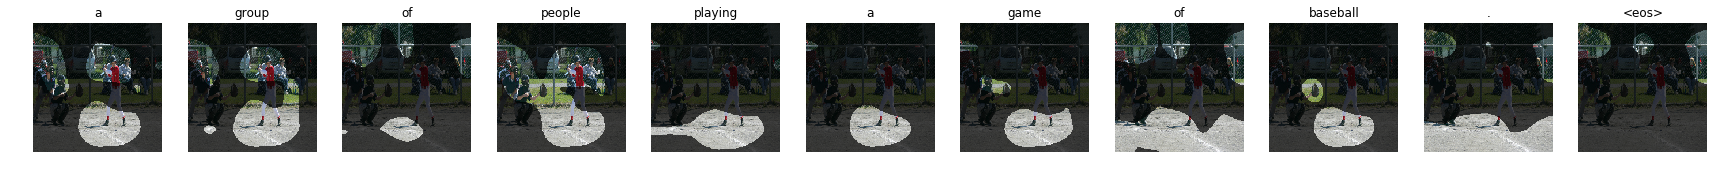

('ID:', u'COCO_val2014_000000054593.jpg')
('True:', u'the action in an organized youth baseball game . <eos>')
('Gen:', u'a group of people playing a game of baseball . <eos>')
----------
224


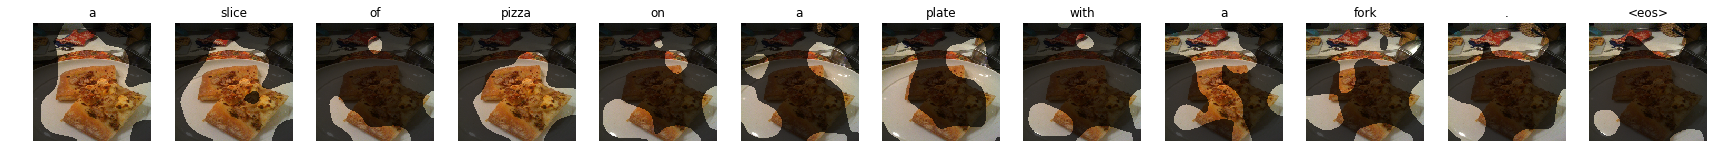

('ID:', u'COCO_val2014_000000520787.jpg')
('True:', u'two slices of pizza are being served on a plate . <eos>')
('Gen:', u'a slice of pizza on a plate with a fork . <eos>')
----------
224


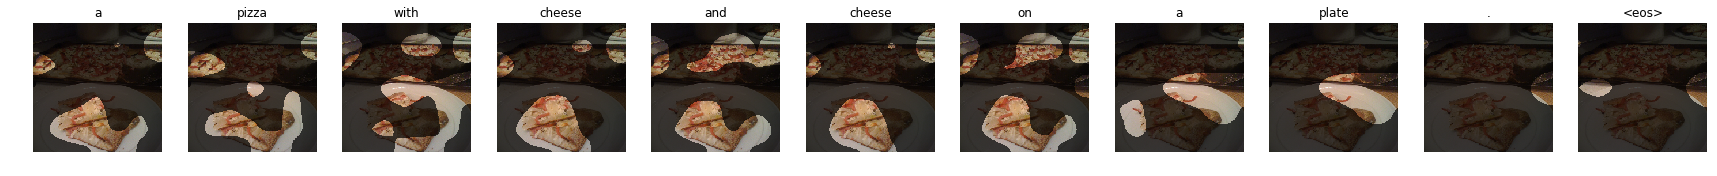

('ID:', u'COCO_val2014_000000574095.jpg')
('True:', u'there are two slices of pizza in front of the rest of the pizza . <eos>')
('Gen:', u'a pizza with cheese and cheese on a plate . <eos>')
----------
224


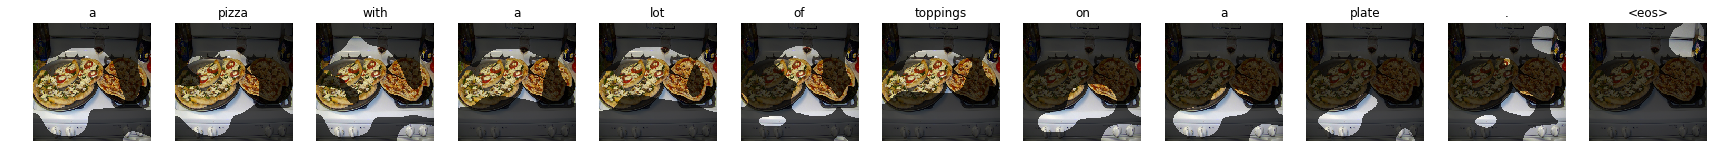

('ID:', u'COCO_val2014_000000251920.jpg')
('True:', u'two cut up pizzas sitting on pizza pans on top of a stove . <eos>')
('Gen:', u'a pizza with a lot of toppings on a plate . <eos>')
----------
224


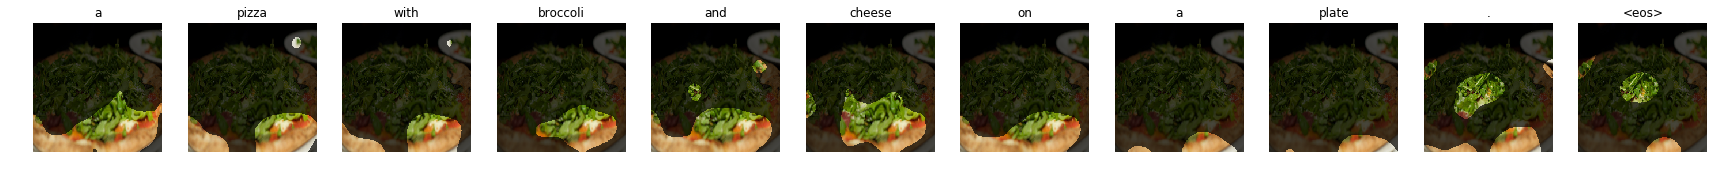

('ID:', u'COCO_val2014_000000525646.jpg')
('True:', u'a pizza topped with pepperoni and extra spinach . <eos>')
('Gen:', u'a pizza with broccoli and cheese on a plate . <eos>')
----------
224


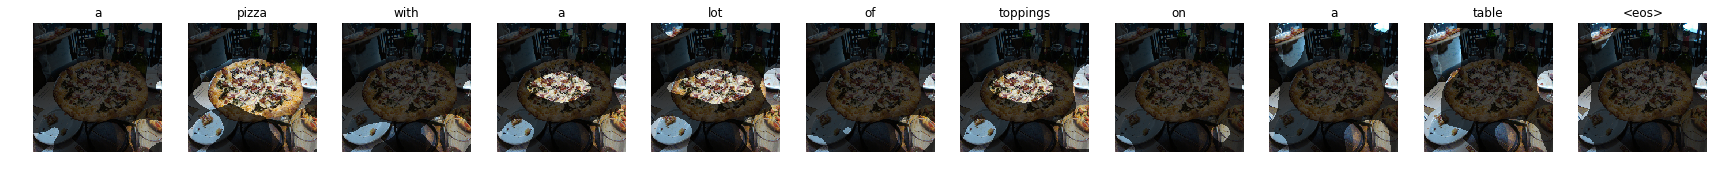

('ID:', u'COCO_val2014_000000116208.jpg')
('True:', u'a very large pizza covered in cheese and toppings . <eos>')
('Gen:', u'a pizza with a lot of toppings on a table <eos>')
----------
224


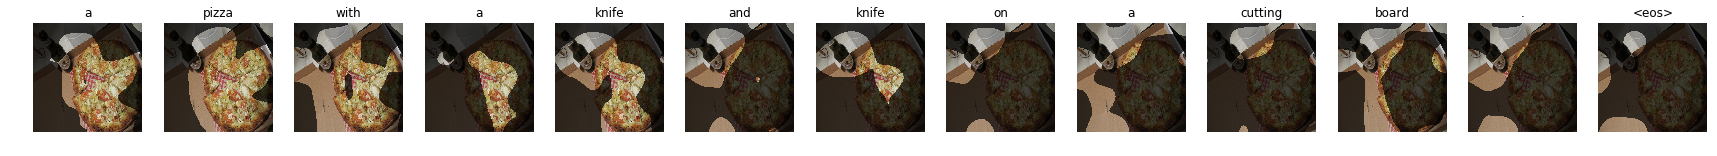

('ID:', u'COCO_val2014_000000361351.jpg')
('True:', u'sliced pizza in delivery box with bottle beverage on table . <eos>')
('Gen:', u'a pizza with a knife and knife on a cutting board . <eos>')
----------


In [11]:
from utils.im_proc import read_image
import matplotlib.pyplot as plt  
%matplotlib inline
import os
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.filters import gaussian_filter
import copy

IMPATH = os.path.join(args_dict.coco_path,'images','val' + args_dict.year)
count = 0

for [im,prevs],cap,imids in val_gen:
    
    # store all attention maps here
    print args_dict.imsize
    masks = np.zeros((args_dict.seqlen, args_dict.imsize,args_dict.imsize))
    
    # first previous word is <start> (idx 1 in vocab)
    prevs = np.ones((N,1))
    
    # store all predicted words in sequence here
    word_idxs = np.zeros((N,args_dict.seqlen))
    
    imname = imids[0]['file_name']
    img = read_image(os.path.join(IMPATH,imname),(args_dict.imsize,args_dict.imsize))

    # loop to get sequence of predicted words
    for i in range(args_dict.seqlen):

        preds,att = extractor.predict([im,prevs]) #(N,1,vocab_size)
        
        # attention map manipulation for display
        s_att = np.shape(att)[-1]
        att = np.reshape(att,(s_att,))
        
        if args_dict.sgate:
            att = att[:-1] # remove the sentinel weight from attention weights
        s = int(np.sqrt(s_att))
        att = np.reshape(att,(s,s))
        att = zoom(att,float(img.shape[0])/att.shape[-1],order=1)
        att = gaussian_filter(att,sigma=sig)
        att = (att - (np.min(att)))/(np.max(att) - np.min(att))
        att[att>th] = 1
        att[att<=th] = 0.3
        masks[i] = att

        # store predicted word and set previous word for next step
        preds = preds.squeeze()
        word_idxs[:,i] = np.argmax(preds,axis=-1)
        prevs = np.argmax(preds,axis=-1)
        prevs = np.reshape(prevs,(N,1))

    # find words for predicted word idxs
    pred_caps = idx2word(word_idxs,inv_vocab)
    true_caps = idx2word(np.argmax(cap,axis=-1),inv_vocab)
    
    # display predictions with attention maps
    n_words = len(pred_caps[0])
    f, axarr = plt.subplots(1,n_words,figsize=figsize)
    for i in range(n_words):
        im = copy.deepcopy(img)
        for c in range(3):
            im[:,:,c] = im[:,:,c]*masks[i]
        axarr[i].imshow(im)
        axarr[i].axis('off')
        axarr[i].set_title(pred_caps[0][i])

    plt.show()
    
    pred_cap = ' '.join(pred_caps[0])
    true_cap = ' '.join(true_caps[0])
    
    # true captions
    print ("ID:", imids[0]['file_name'])
    print ("True:", true_cap)
    print ("Gen:", pred_cap)
    print ("-"*10)

    model.reset_states()
    count+=1
    if count > 10:
        break